In [26]:
import os
import time
import netCDF4
import datetime 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

In [ ]:
date_min = "20240401"
date_max = "20250331"
#
N_obs_min = 50
SIC_threshold = 0
lead_times_figure = [0, 3, 6, 9] 
sizefont = 20
#
paths = {}
paths["AICE"] = "/lustre/storeB/project/copernicus/cosi/AICE/archive/"
paths["AMSR2"] = "/lustre/storeB/project/copernicus/cosi/WP3/Operational/AMSR2_obs/"
paths["output"] = "/lustre/storeB/users/cyrilp/AICE/Figures/Paper/"
#
map_params = {"LAND_highres": cpf.NaturalEarthFeature("physical", "land", "50m", edgecolor = "face", facecolor = "tan", linewidth = 0.1),
              "map_extent": (-22, 53, 68, 90),
              "map_proj": ccrs.LambertAzimuthalEqualArea(central_longitude = 0, central_latitude = 79, false_easting = 0.0, false_northing = 0.0, globe = None),
              "levels_RMSE": np.linspace(0, 40, 41),
              "levels_improvement": np.linspace(-40, 40, 41), 
              "norm_RMSE": BoundaryNorm(np.linspace(0, 40, 41), 256),
              "norm_improvement": BoundaryNorm(np.linspace(-40, 40, 41), 256),
              "colormap_RMSE": "gnuplot",
              "colormap_improvement": "RdYlBu",
              "map_extent_domains": (-22, 53, 68, 90),}

# Make statistics

In [28]:
class make_stats():
    def __init__(self, date_min, date_max, N_obs_min, SIC_threshold, paths):
        self.date_min = date_min
        self.date_max = date_max
        self.N_obs_min = N_obs_min
        self.SIC_threshold = SIC_threshold
        self.paths = paths
    
    def make_list_dates(self):
        current_date = datetime.datetime.strptime(self.date_min, "%Y%m%d")
        end_date = datetime.datetime.strptime(self.date_max, "%Y%m%d")
        list_dates = []
        while current_date <= end_date:
            date_str = current_date.strftime("%Y%m%d")
            list_dates.append(date_str)
            current_date = current_date + datetime.timedelta(days = 1)
        return list_dates
    
    def load_AICE(self, start_date):
        AICE = {}
        filename = self.paths["AICE"] + "AICE_forecasts_" + start_date + "T000000Z.nc"
        if os.path.isfile(filename) == True:
            with netCDF4.Dataset(filename, "r") as nc:
                for var in nc.variables:
                    AICE[var] = nc.variables[var][:]
        return AICE 

    def load_AMSR2(self, date_task):
        AMSR2 = {}
        filename = self.paths["AMSR2"] + date_task[0:4] + "/" + date_task[4:6] + "/" + "AMSR2_SIC_AICE_grid_" + date_task + "T000000Z.nc"
        if os.path.isfile(filename) == True:
             with netCDF4.Dataset(filename, "r") as nc:
                for var in nc.variables:
                    AMSR2[var] = nc.variables[var][:]
        return AMSR2

    def calculate_RMSE(self, Datasets):
        RMSE = {}
        AICE = self.load_AICE(start_date = "20240401")
        for lt in range(0, len(AICE["time"])):
            N_obs = np.sum(Datasets["AMSR2_leadtime_" + str(lt)] > self.SIC_threshold, axis = 0)
            idx_select = N_obs >= self.N_obs_min 
            RMSE["AMSR2_persistence_leadtime_" + str(lt)] = np.sqrt(np.sum(((Datasets["persistence_" + str(lt)] - Datasets["AMSR2_leadtime_" + str(lt)]) ** 2), axis = 0) / N_obs)
            RMSE["AICE_leadtime_" + str(lt)] = np.sqrt(np.sum(((Datasets["AICE_leadtime_" + str(lt)] - Datasets["AMSR2_leadtime_" + str(lt)]) ** 2), axis = 0) / N_obs)       
            RMSE["AMSR2_persistence_leadtime_" + str(lt)][idx_select == False] = np.nan
            RMSE["AICE_leadtime_" + str(lt)][idx_select == False] = np.nan
            RMSE["AICE_improvement_" + str(lt)] = 100 * (1 - RMSE["AICE_leadtime_" + str(lt)] / RMSE["AMSR2_persistence_leadtime_" + str(lt)])
        return RMSE

    def __call__(self):
        Datasets = {}
        list_dates = self.make_list_dates()
        
        for start_date in list_dates:
            print(start_date)
            date_persistence = (datetime.datetime.strptime(start_date, "%Y%m%d") - datetime.timedelta(days = 1)).strftime("%Y%m%d")
            AMSR2_persistence = self.load_AMSR2(date_task = date_persistence)
            if len(AMSR2_persistence) > 0:
                AICE = self.load_AICE(start_date = start_date)
                if len(AICE) > 0:
                    for lt in range(0, len(AICE["time"])):
                        date_forecast = (datetime.datetime.strptime(start_date, "%Y%m%d") + datetime.timedelta(days = lt)).strftime("%Y%m%d")
                        AMSR2 = self.load_AMSR2(date_task = date_forecast)
                        if len(AMSR2) > 0:
                            if start_date == self.date_min:
                                Datasets["persistence_" + str(lt)] = np.copy(AMSR2_persistence["SIC"])
                                Datasets["AMSR2_leadtime_" + str(lt)] = np.copy(AMSR2["SIC"])
                                Datasets["AICE_leadtime_" + str(lt)] = np.expand_dims(AICE["SIC"][lt,:,:], axis = 0)
                            else: 
                                Datasets["persistence_" + str(lt)] = np.concatenate((Datasets["persistence_" + str(lt)], AMSR2_persistence["SIC"]), axis = 0)
                                Datasets["AMSR2_leadtime_" + str(lt)] = np.concatenate((Datasets["AMSR2_leadtime_" + str(lt)], AMSR2["SIC"]), axis = 0)
                                Datasets["AICE_leadtime_" + str(lt)] = np.concatenate((Datasets["AICE_leadtime_" + str(lt)], np.expand_dims(AICE["SIC"][lt,:,:], axis = 0)), axis = 0)
        
        RMSE = self.calculate_RMSE(Datasets = Datasets)
        return(RMSE, AICE)

# Make figure

In [29]:
def make_maps_RMSE_improvements(RMSE, AICE, lead_times_figure, map_params, paths, sizefont, date_min, date_max, saving = False):
    caption_ticks = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]

    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, axs = plt.subplots(2, len(lead_times_figure), figsize = (20, 10), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.2, wspace = 0.15)
    axs = axs.ravel()

    for lti, leadtime in enumerate(lead_times_figure):
        axs = plt.subplot(2, len(lead_times_figure), lti + 1, projection = map_params["map_proj"])
        axs.set_extent(map_params["map_extent"], crs = ccrs.PlateCarree())
        axs.add_feature(map_params["LAND_highres"], zorder = 1)
        cs = axs.pcolormesh(AICE["lon"], AICE["lat"], RMSE["AICE_leadtime_" + str(leadtime)][0:-1, 0:-1], transform = ccrs.PlateCarree(), norm = map_params["norm_RMSE"], cmap = map_params["colormap_RMSE"], zorder = 0, shading = "flat")
        if leadtime == 0:
            axs.set_title("Lead time: " + str(leadtime + 1) + " day", fontsize = sizefont)
        else:
            axs.set_title("Lead time: " + str(leadtime + 1) + " days", fontsize = sizefont)
        axs.text(-0.1, 0.01, caption_ticks[lti], fontsize = sizefont, ha = "left", transform = axs.transAxes)
    
    cbar_ax = fig.add_axes([0.91, 0.56, 0.02, 0.29])
    cbar = fig.colorbar(cs, cax = cbar_ax, ticks = map_params["levels_RMSE"][1:-1], extend = "both")
    cbar.set_label("RMSE (%)", fontsize = sizefont * 0.9)
    tick_locator = ticker.MaxNLocator(nbins = 8)
    cbar.locator = tick_locator
    cbar.update_ticks()

    for lti, leadtime in enumerate(lead_times_figure):
        axs = plt.subplot(2, len(lead_times_figure), len(lead_times_figure) + lti + 1, projection = map_params["map_proj"])
        axs.set_extent(map_params["map_extent"], crs = ccrs.PlateCarree())
        axs.add_feature(map_params["LAND_highres"], zorder = 1)
        cs = axs.pcolormesh(AICE["lon"], AICE["lat"], RMSE["AICE_improvement_" + str(leadtime)][0:-1, 0:-1], transform = ccrs.PlateCarree(), norm = map_params["norm_improvement"], cmap = map_params["colormap_improvement"], zorder = 0, shading = "flat")
        if leadtime == 0:
            axs.set_title("Lead time: " + str(leadtime + 1) + " day", fontsize = sizefont)
        else:
            axs.set_title("Lead time: " + str(leadtime + 1) + " days", fontsize = sizefont)
        axs.text(-0.1, 0.01, caption_ticks[len(lead_times_figure) + lti], fontsize = sizefont, ha = "left", transform = axs.transAxes)

    cbar_ax = fig.add_axes([0.91, 0.14, 0.02, 0.29])
    cbar = fig.colorbar(cs, cax = cbar_ax, ticks = map_params["levels_improvement"][1:-1], extend = "both")
    cbar.set_label("RMSE improvement (%)", fontsize = sizefont * 0.9)
    tick_locator = ticker.MaxNLocator(nbins = 8)
    cbar.locator = tick_locator
    cbar.update_ticks()


    # Add centered titles using fig.text
    fig.text(0.5, 0.92, "RMSE of the sea ice concentration", ha='center', fontsize=sizefont, fontweight="bold")
    fig.text(0.5, 0.5, "RMSE improvement compared to persistence of AMSR2 observations", ha='center', fontsize=sizefont, fontweight="bold")

    if saving == True:
        plt.savefig(paths["output"] + "Maps_RMSE_improvement_" + date_min + "_" + date_max + ".png", bbox_inches = "tight", transparent = False, dpi = 300) 
    else:
        plt.show()

# Main

20240401
20240402
20240403
20240404
20240405


/tmp/ipykernel_658987/2635567096.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs = plt.subplot(2, len(lead_times_figure), lti + 1, projection = map_params["map_proj"])
/tmp/ipykernel_658987/2635567096.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs = plt.subplot(2, len(lead_times_figure), lti + 1, projection = map_params["map_proj"])
/tmp/ipykernel_658987/2635567096.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs = plt.subplot(2, len(lead_times_figure), lti + 1, projection = map_params["map_proj"])
/tmp/ipykernel_658987/2635567096.py:12: MatplotlibDeprecationWarning: Auto-removal of

Computing time 6.5606279373168945


<Figure size 640x480 with 0 Axes>

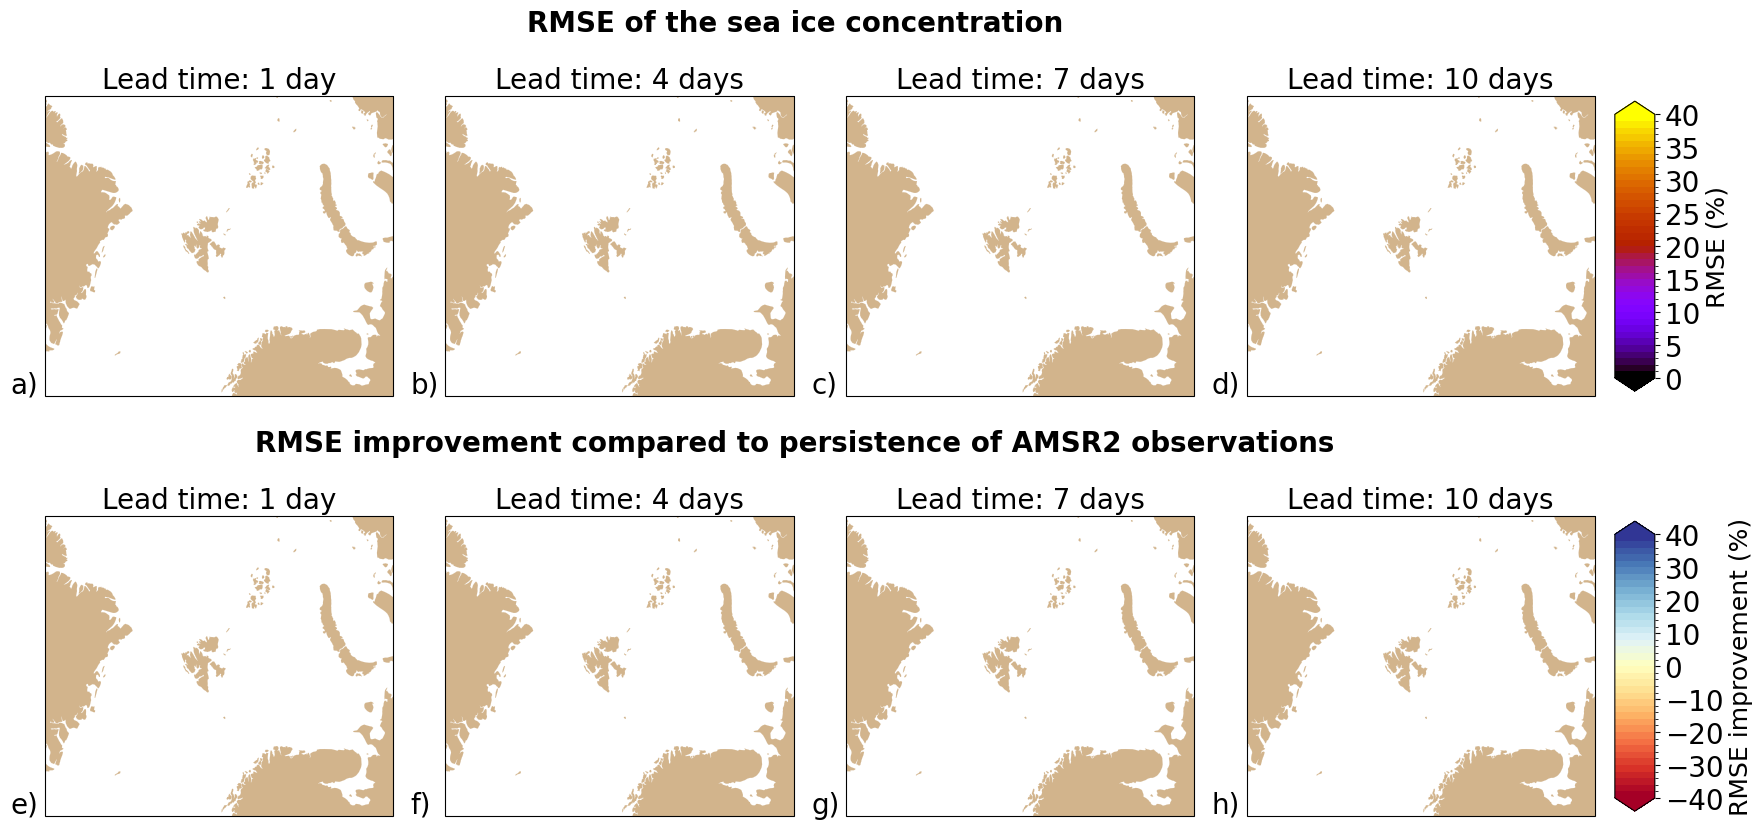

In [30]:
t0 = time.time()

RMSE, AICE = make_stats(date_min = date_min, 
                        date_max = date_max, 
                        N_obs_min = N_obs_min, 
                        SIC_threshold = SIC_threshold, 
                        paths = paths)()

make_maps_RMSE_improvements(RMSE = RMSE, 
                            AICE = AICE, 
                            lead_times_figure = lead_times_figure, 
                            map_params = map_params, 
                            paths = paths,
                            sizefont = sizefont, 
                            date_min = date_min,
                            date_max = date_max,
                            saving = True)
                            
print("Computing time", time.time() - t0)